In [1]:
import cv2
import numpy as np
import pytesseract
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import matplotlib.pyplot as plt

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

/Users/shubhamgulati/.pyenv/versions/3.10.6/envs/mindcase-scraping/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# Specify the path to the ChromeDriver executable
PATH = r"/Users/shubhamgulati/Downloads/chromedriver-mac-arm64/chromedriver"
# PATH = r"/opt/homebrew/bin/chromedriver"

# Set the ChromeDriver executable path using the Service class
service = webdriver.chrome.service.Service(PATH)

In [4]:
def extract_captcha():
    # Load the CAPTCHA image
    image = cv2.imread("captcha.png")

    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    plt.imshow(image)
    plt.show()
    print(generated_text)

    return generated_text

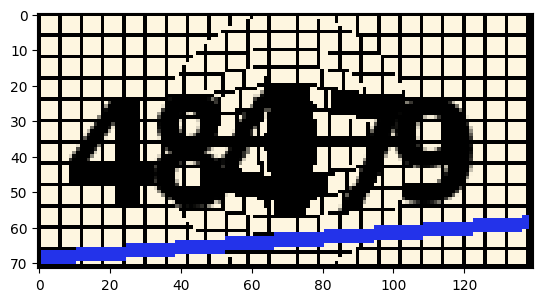

48479
Extracted 5-Digit Number: 48479
[]


In [23]:
# Create a Chrome WebDriver instance with the service
driver = webdriver.Chrome(service=service)

# Now you can use the driver to navigate to a URL
driver.get("https://gujarathc-casestatus.nic.in/gujarathc/")

# Locate the "FREE TEXT SEARCH" element by its 'alt' attribute
search_element = driver.find_element(By.XPATH, '//img[@alt="FREE TEXT SEARCH"]')
search_element.click()

wait = WebDriverWait(driver, 10)

# Use an explicit wait to wait for the "st1" element to be present
search_input = wait.until(EC.presence_of_element_located((By.ID, "st1")))
search_input.send_keys("hello")

# Locate and click the "Go" button based on the provided HTML structure
go_button = driver.find_element(By.XPATH, '//button[@onclick="openCaptcha();"]')
go_button.click()

# Wait for the CAPTCHA image to load
captcha_element = wait.until(EC.presence_of_element_located((By.ID, "stringCaptcha")))

# Save a screenshot of the CAPTCHA image
with open("captcha.png", "wb") as captcha_file:
    captcha_file.write(captcha_element.screenshot_as_png)

# Extract the 5-digit number from the CAPTCHA
captcha_text = extract_captcha()
print("Extracted 5-Digit Number:", captcha_text)

# Find and fill the input field
answer_input = wait.until(EC.presence_of_element_located((By.ID, "challengestring")))
answer_input.send_keys(captcha_text)

# Click the "Search" button
search_button = driver.find_element(By.ID, "search_btn")
search_button.click()

wait.until(EC.presence_of_element_located((By.ID, "users_info")))

# similar_elements = driver.find_elements(By.TAG_NAME, "a")
# for element in similar_elements:
#     print(element.get_attribute('onclick'))

pdfs = driver.find_elements(By.XPATH, '//a[contains(@onclick, "downloadPdf")]')
print(pdfs)
for pdf in pdfs:
    print(pdf.get_attribute("onclick"))

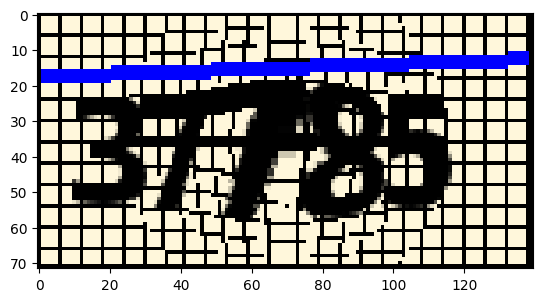

37785
Extracted 5-Digit Number: 37785


In [10]:
import cv2
import numpy as np
import pytesseract
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Function to preprocess and extract the CAPTCHA
def extract_captcha_text(driver):
    # Wait for the CAPTCHA image to load
    captcha_element = wait.until(EC.presence_of_element_located((By.ID, "stringCaptcha")))
    captcha_image_url = captcha_element.get_attribute("src")

    # Download the CAPTCHA image
    captcha_response = requests.get(captcha_image_url)
    with open("captcha.png", "wb") as captcha_file:
        captcha_file.write(captcha_response.content)

    # Load the CAPTCHA image
    captcha_img = cv2.imread("captcha.png")

    # Improve CAPTCHA image quality
    # Apply blurring to the black grid background
    black_grid_mask = cv2.inRange(captcha_img, (0, 0, 0), (100, 100, 100))
    blurred_black_grid = cv2.GaussianBlur(captcha_img, (9, 9), 0, dst=captcha_img, mask=black_grid_mask)

    # Apply blurring to the thick red line
    red_line_mask = cv2.inRange(captcha_img, (0, 0, 100), (0, 0, 255))
    blurred_red_line = cv2.GaussianBlur(captcha_img, (9, 9), 0, dst=captcha_img, mask=red_line_mask)

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(captcha_img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to isolate the digits
    _, thresholded = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Perform morphological operations to remove noise
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Find contours of the digits
    contours, _ = cv2.findContours(sure_bg.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours (noise)
    MIN_CONTOUR_AREA = 100
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > MIN_CONTOUR_AREA]

    # Create a mask to remove the background
    mask = np.zeros(gray_img.shape, np.uint8)
    cv2.drawContours(mask, filtered_contours, -1, 255, -1)

    # Remove the thick red lines by inpainting (assuming the line is continuous)
    line_mask = cv2.inRange(captcha_img, (0, 0, 100), (0, 0, 255))
    inpainted_img = cv2.inpaint(captcha_img, line_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # Apply the mask to isolate the digits
    result = cv2.bitwise_and(inpainted_img, inpainted_img, mask=mask)

    # Extract the text from the cleaned image using OCR
    captcha_text = pytesseract.image_to_string(result, config='--psm 6')

    return captcha_text

# Specify the path to the ChromeDriver executable
PATH = r"/Users/shubhamgulati/Downloads/chromedriver-mac-arm64/chromedriver"

# PATH = r"/Users/shubhamgulati/Downloads/chromedriver_mac64/chromedriver"
# PATH = r'/usr/local/bin/chromedriver'

# Set the ChromeDriver executable path using the Service class
service = webdriver.chrome.service.Service(PATH)

# Create a Chrome WebDriver instance with the service
driver = webdriver.Chrome(service=service)

# Now you can use the driver to navigate to a URL
driver.get("https://gujarathc-casestatus.nic.in/gujarathc/")

# Locate the "FREE TEXT SEARCH" element by its 'alt' attribute
search_element = driver.find_element(By.XPATH, '//img[@alt="FREE TEXT SEARCH"]')
search_element.click()

# Use an explicit wait to wait for the "st1" element to be present
wait = WebDriverWait(driver, 10)
search_input = wait.until(EC.presence_of_element_located((By.ID, "st1")))
search_input.send_keys("iim")

# Locate and click the "Go" button based on the provided HTML structure
go_button = driver.find_element(By.XPATH, '//button[@onclick="openCaptcha();"]')
go_button.click()

# Extract the 5-digit number from the CAPTCHA
captcha_text = extract_captcha(driver)
print("Extracted 5-Digit Number:", captcha_text)

# Find and fill the input field
answer_input = wait.until(EC.presence_of_element_located((By.ID, "challengestring")))
answer_input.send_keys(captcha_text)

# Click the "Search" button
search_button = driver.find_element(By.ID, "search_btn")
search_button.click()



In [20]:
from PIL import Image
import pytesseract

image = Image.open('captcha.png')

text = pytesseract.image_to_string(image)

print(text)


In [16]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import matplotlib.pyplot as plt

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


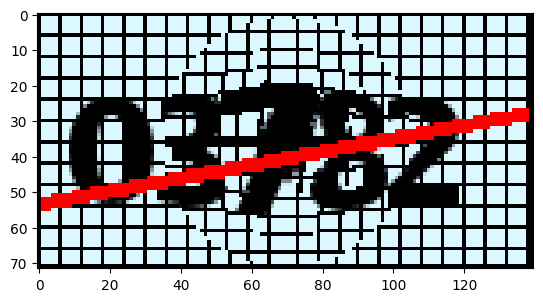

03782


In [19]:
image = Image.open('captcha2.png')

pixel_values = processor(images=image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

plt.imshow(image)
plt.show()
print(generated_text)

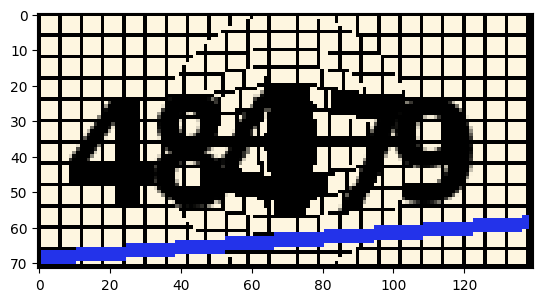

''

In [24]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("zenoda/trocr-captcha-killer")
model = VisionEncoderDecoderModel.from_pretrained("zenoda/trocr-captcha-killer")
